<a href="https://colab.research.google.com/github/kuzovkov/neural-university/blob/main/%D0%94%D0%97_Ultra_Pro_%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%A1%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%7C_%D0%A3%D0%98%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используя базу данных автомобилей, создайте сеть с точностью распознавания не ниже 93% на проверочной выборке.

Для решения задачи вы можете использовать любой подход:
- модель без аугментации данных
- аугментация данных с помощью ImageDataGenerator
- аугментация данных с помощью самописного генератора изображений
- использовать готовую архитектуру из набора `tf.keras.applications` (Обратите внимание: на занятии мы не рассматривали данный модуль фреймворка Керас. Ваша задача: попробовать самостоятельно разобраться в приципах его работы. В разборе домашнего задания вы получите ссылку на ноутбук Базы Знаний УИИ, где подробно раскрывается вопрос использования готовых архитектур)

In [1]:
# Ваше решение

import gdown

# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip', None, quiet=True)

# Разархивация датасета в директорию 'content/cars'
!unzip -qo "middle_fmr.zip" -d /content/cars

import os
# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/cars/'

# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

from PIL import Image                     # Отрисовка изображений
import random                             # Генерация случайных чисел
import matplotlib.pyplot as plt           # Отрисовка графиков

%matplotlib inline


Количество классов: 3, метки классов: ['Ferrari', 'Mercedes', 'Renault']


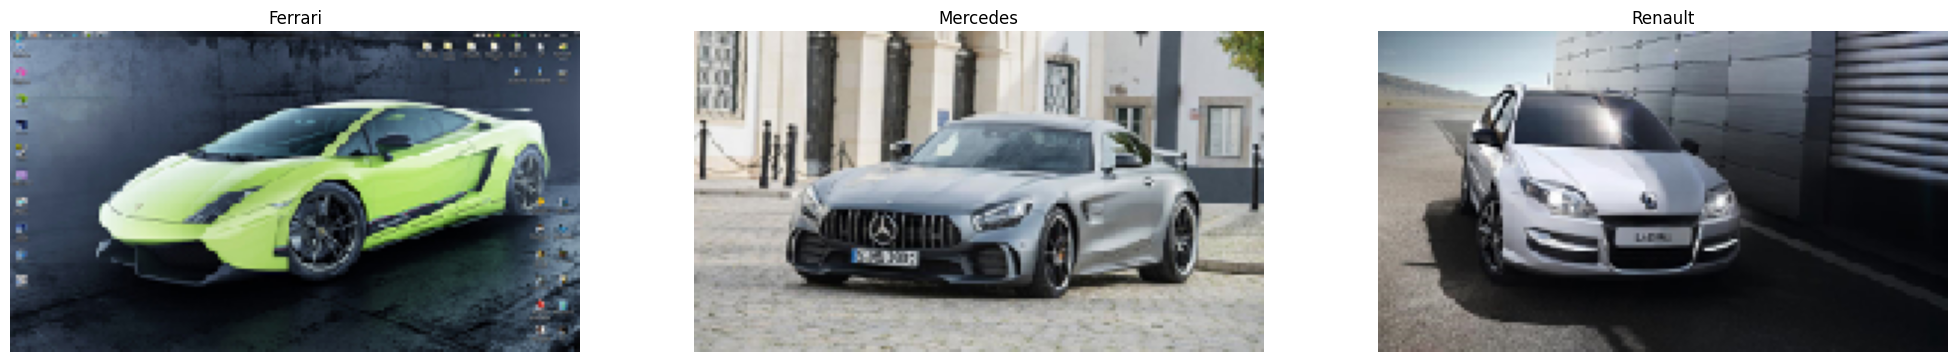

In [2]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(25, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):
    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'
    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))
    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [3]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} машин')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print('Общий размер базы для обучения:', len(data_labels))

Размер класса Ferrari составляет 1088 машин
Размер класса Mercedes составляет 1161 машин
Размер класса Renault составляет 1178 машин
Общий размер базы для обучения: 3427


In [4]:
# Задание единых размеров изображений

IMG_WIDTH = 128                           # Ширина изображения
IMG_HEIGHT = 64                           # Высота изображения

import numpy as np                        # Библиотека работы с массивами

data_images = []                          # Пустой список для данных изображений

for file_name in data_files:
    # Открытие и смена размера изображения
    img = Image.open(file_name).resize((IMG_WIDTH, IMG_HEIGHT))
    img_np = np.array(img)                # Перевод в numpy-массив
    data_images.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку

x_data = np.array(data_images)            # Перевод общего списка изображений в numpy-массив
y_data = np.array(data_labels)            # Перевод общего списка меток класса в numpy-массив

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

# Нормированние массива изображений
x_data = x_data / 255.

В массив собрано 3427 фотографий следующей формы: (64, 128, 3)
Общий массив данных изображений следующей формы: (3427, 64, 128, 3)
Общий массив меток классов следующей формы: (3427,)


In [5]:
# Подключение нужных слоев из модуля tensorflow.keras.layers

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization

# Создание модели последовательной архитектуры
model = Sequential()

# Первый сверточный блок
model.add(Conv2D(256, (3, 3), name='First_C', padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))  # (64,128,3) --> (64,128,256) меняется кол-во фильтров
model.add(BatchNormalization(name='First_B'))  # (64,128,256) --> (64,128,256) нет изменений

# Второй сверточный блок
model.add(Conv2D(256, (3, 3), name='Second_C', padding='same', activation='relu'))  # (64,128,256) --> (64,128,256) нет изменений
model.add(MaxPooling2D(pool_size=(3, 3), name='Second_M'))  # сжимает размер в три раза, с потерей, т.к. padding='valid', глубина не изм. (64,128,256) --> (21,42,256)

# Третий сверточный блок
model.add(Conv2D(256, (3, 3), name='Third_C', padding='same', activation='relu'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(BatchNormalization(name='Third_B'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(Dropout(0.2, name='Third_D'))  # (21,42,256) --> (21,42,256) нет изменений

# Четвертый сверточный блок
model.add(Conv2D(256, (3, 3), name='Fourth_C', padding='same', activation='relu'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(MaxPooling2D(pool_size=(3, 3), name='Fourth_M'))  # сжимает размер в три раза, хотя padding='valid', потерь нет, т.к. делится нацело, глубина не изм. (21,42,256) --> (7,14,256)
model.add(Dropout(0.2, name='Fourth_D'))  # (7,14,256) --> (7,14,256) нет изменений

# Пятый сверточный блок
model.add(Conv2D(512, (3, 3), name='Fifth_D', padding='same', activation='relu'))  # (7,14,256) --> (7,14,512) меняется количество фильтров
model.add(BatchNormalization(name='Fifth_B'))  # (7,14,512) --> (7,14,512) нет изменений

# Шестой сверточный блок
model.add(Conv2D(1024, (3, 3), name='Sixth_C', padding='same', activation='relu'))  # (7,14,1024) --> (7,14,1024) меняется кол-во фильтров
model.add(MaxPooling2D(pool_size=(3, 3), name='Sixth_M'))  # сжимает размер в три раза, с потерей, т.к. padding='valid', глубина не изм. (7,14,1024) --> (2,4,1024)
model.add(Dropout(0.2, name='Sixth_D'))  # (2,4,1024) --> (2,4,1024) нет изменений

# Блок классификации
model.add(Flatten(name='Class_1'))  # слой преобразования многомерных данных в одномерные (2,4,1024) --> (2*4*1024) --> (8192)
model.add(Dense(2048, activation='relu', name='Class_2'))  # полносвязный слой, меняется кол-во нейронов (8192) --> (2048)
model.add(Dense(4096, activation='relu', name='Class_3'))  # полносвязный слой, меняется кол-во нейронов (2048) --> (4096)
model.add(Dense(CLASS_COUNT, activation='softmax', name='Class_4'))  # выходной полносвязный слой, кол-во нейронов = количество классов (4096) --> (3)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ First_C (Conv2D)                     │ (None, 64, 128, 256)        │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ First_B (BatchNormalization)         │ (None, 64, 128, 256)        │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Second_C (Conv2D)                    │ (None, 64, 128, 256)        │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Second_M (MaxPooling2D)              │ (None, 21, 42, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Third_C (Conv2D)                     │ (None, 21, 42, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Third_B (BatchNormalization)         │ (None, 21, 42, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Third_D (Dropout)                    │ (None, 21, 42, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fourth_C (Conv2D)                    │ (None, 21, 42, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fourth_M (MaxPooling2D)              │ (None, 7, 14, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fourth_D (Dropout)                   │ (None, 7, 14, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fifth_D (Conv2D)                     │ (None, 7, 14, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fifth_B (BatchNormalization)         │ (None, 7, 14, 512)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sixth_C (Conv2D)                     │ (None, 7, 14, 1024)         │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sixth_M (MaxPooling2D)               │ (None, 2, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sixth_D (Dropout)                    │ (None, 2, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_1 (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_2 (Dense)                      │ (None, 2048)                │      16,779,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_3 (Dense)                      │ (None, 4096)                │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_4 (Dense)                      │ (None, 3)                   │          12,291 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,865,539 (125.37 MB)

 Trainable params: 32,863,491 (125.36 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [6]:
# Подключение оптимизатора Adam
from tensorflow.keras.optimizers import Adam

# Компиляция модели
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [7]:
# Обучение модели сверточной нейронной сети подготовленных данных

history = model.fit(x_data,  # ----------------- x_train, примеры набора данных
                           y_data,  # ----------------- y_train, метки примеров набора данных
                           validation_split=0.2,  # --- 0.2 - доля данных для валидационной (проверочной) выборки, 1-0.2=0.8 останется в обучающей
                           shuffle=True,  # ----------- перемешивание данных для равномерного обучения, соответствие экземпляра и метки сохраняется
                           batch_size=25,  # ---------- размер пакета, который обрабатывает нейронка перед одним изменением весов
                           epochs=35,  # -------------- epochs - количество эпох обучения
                           verbose=1)  # -------------- 0 - не визуализировать ход обучения, 1 - визуализировать

Epoch 1/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 62s 353ms/step - accuracy: 0.5704 - loss: 1.2307 - val_accuracy: 0.0000e+00 - val_loss: 2.2412
Epoch 2/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 166ms/step - accuracy: 0.6651 - loss: 0.8095 - val_accuracy: 0.0000e+00 - val_loss: 2.9539
Epoch 3/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - accuracy: 0.7080 - loss: 0.7146 - val_accuracy: 0.0000e+00 - val_loss: 2.8551
Epoch 4/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - accuracy: 0.7126 - loss: 0.6980 - val_accuracy: 0.0000e+00 - val_loss: 3.5022
Epoch 5/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.7399 - loss: 0.6012 - val_accuracy: 0.0015 - val_loss: 2.5769
Epoch 6/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.7612 - loss: 0.5988 - val_accuracy: 0.0510 - val_loss: 2.5058
Epoch 7/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 183ms/step - accuracy: 0.8006 - loss: 0.5096 - val_accuracy: 0.1414 - val_loss: 2.3658
Epoch 8/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - accuracy: 

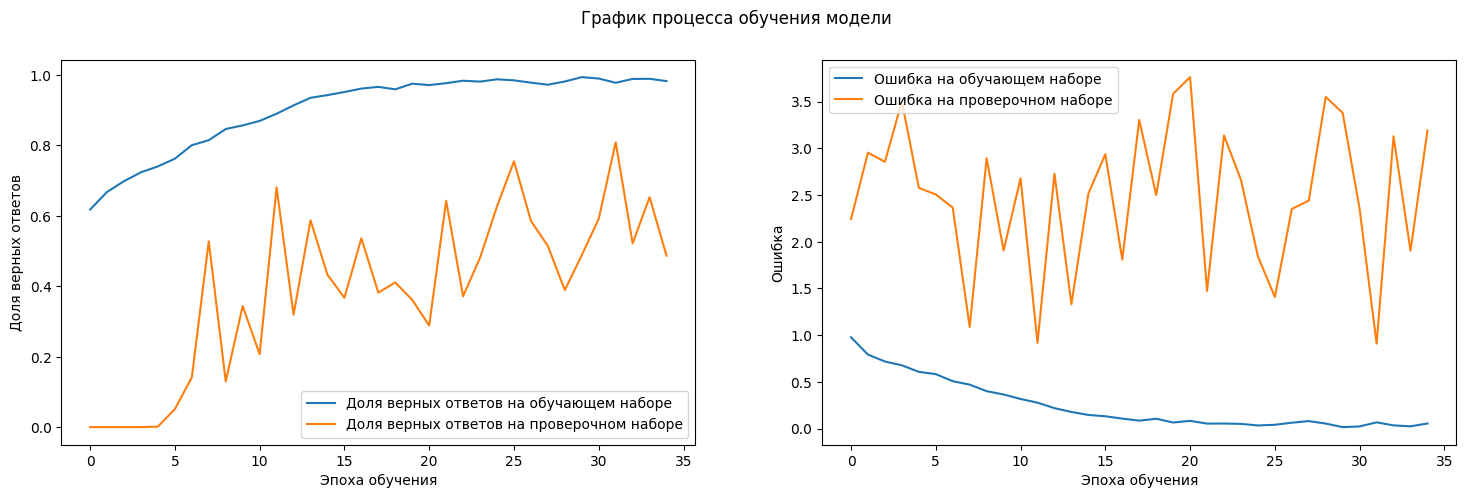

In [8]:
# Вывод оценки ее работы на проверочных выборках
# Вывод графиков точности и ошибки
figsize=(18, 5)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
fig.suptitle('График процесса обучения модели')
ax1.plot(history.history['accuracy'],
           label='Доля верных ответов на обучающем наборе')
ax1.plot(history.history['val_accuracy'],
           label='Доля верных ответов на проверочном наборе')
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel('Эпоха обучения')
ax1.set_ylabel('Доля верных ответов')
ax1.legend()

ax2.plot(history.history['loss'],
           label='Ошибка на обучающем наборе')
ax2.plot(history.history['val_loss'],
           label='Ошибка на проверочном наборе')
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel('Эпоха обучения')
ax2.set_ylabel('Ошибка')
ax2.legend()
plt.show()


In [9]:
# Задание гиперпараметров

TRAIN_PATH          = '/content/cars'       # Папка для обучающего набора данных
TEST_PATH           = '/content/cars_test'  # Папка для тестового набора данных

TEST_SPLIT          = 0.1                   # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                   # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 128                   # Ширина изображения для нейросети
IMG_HEIGHT          = 64                    # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.7, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = True                  # Горизонтальное отражение разрешено

EPOCHS              = 60                    # Число эпох обучения
BATCH_SIZE          = 24                    # Размер батча для обучения модели
OPTIMIZER           = Adam(0.0001)          # Оптимизатор

In [10]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

try:
  os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
except:
  pass

train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса

    try:
      os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    except:
      pass

    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} машин, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса Ferrari: 1088 машин, для теста выделено файлов: 108
Размер класса Mercedes: 1161 машин, для теста выделено файлов: 116
Размер класса Renault: 1178 машин, для теста выделено файлов: 117
Общий размер базы: 3427, выделено для обучения: 3086, для теста: 341


In [11]:
# Генераторы изображений
# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                   rescale=1. / 255.
                )

In [12]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 2469 images belonging to 3 classes.
Found 617 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


In [13]:
# Функция компиляции и обучения модели нейронной сети
# По окончанию выводит графики обучения

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        # batch_size=batch_size,
                        validation_data=val_data)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода результатов оценки модели на заданных данных

def eval_model(model,
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                    # модель нейронной сети
                             train_data,               # обучающие данные
                             val_data,                 # проверочные данные
                             test_data,                # тестовые данные
                             class_labels=CLASS_LIST,  # список меток классов
                             title='',                 # название модели
                             optimizer=OPTIMIZER,      # оптимизатор
                             epochs=EPOCHS,            # количество эпох обучения
                             batch_size=BATCH_SIZE,    # размер батча
                             graph_size=(20, 5),       # размер полотна для графиков обучения
                             cm_size=(10, 10)          # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, test_data[0][0], test_data[0][1],
               class_labels=class_labels,
               title=title,
               figsize=cm_size)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ First_C (Conv2D)                     │ (None, 64, 128, 256)        │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ First_B (BatchNormalization)         │ (None, 64, 128, 256)        │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Second_C (Conv2D)                    │ (None, 64, 128, 256)        │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Second_M (MaxPooling2D)              │ (None, 21, 42, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Third_C (Conv2D)                     │ (None, 21, 42, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Third_B (BatchNormalization)         │ (None, 21, 42, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Third_D (Dropout)                    │ (None, 21, 42, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fourth_C (Conv2D)                    │ (None, 21, 42, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fourth_M (MaxPooling2D)              │ (None, 7, 14, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fourth_D (Dropout)                   │ (None, 7, 14, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fifth_D (Conv2D)                     │ (None, 7, 14, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fifth_B (BatchNormalization)         │ (None, 7, 14, 512)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sixth_C (Conv2D)                     │ (None, 7, 14, 1024)         │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sixth_M (MaxPooling2D)               │ (None, 2, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sixth_D (Dropout)                    │ (None, 2, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_1 (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_2 (Dense)                      │ (None, 2048)                │      16,779,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_3 (Dense)                      │ (None, 4096)                │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_4 (Dense)                      │ (None, 3)                   │          12,291 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,865,539 (125.37 MB)

 Trainable params: 32,863,491 (125.36 MB)

 Non-trainable params: 2,048 (8.00 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 66s 426ms/step - accuracy: 0.6890 - loss: 0.9189 - val_accuracy: 0.6029 - val_loss: 0.8993
Epoch 2/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 40s 191ms/step - accuracy: 0.7384 - loss: 0.5958 - val_accuracy: 0.6856 - val_loss: 0.7267
Epoch 3/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - accuracy: 0.7748 - loss: 0.5518 - val_accuracy: 0.6775 - val_loss: 0.6969
Epoch 4/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 0.7793 - loss: 0.5286 - val_accuracy: 0.7277 - val_loss: 0.7263
Epoch 5/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.7944 - loss: 0.4846 - val_accuracy: 0.5835 - val_loss: 0.9577
Epoch 6/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.8263 - loss: 0.4622 - val_accuracy: 0.7326 - val_loss: 0.6044
Epoch 7/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.8218 - loss: 0.4390 - val_accuracy: 0.7520 - val_loss: 0.6860
Epoch 8/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - accuracy: 0.8320 - loss: 0

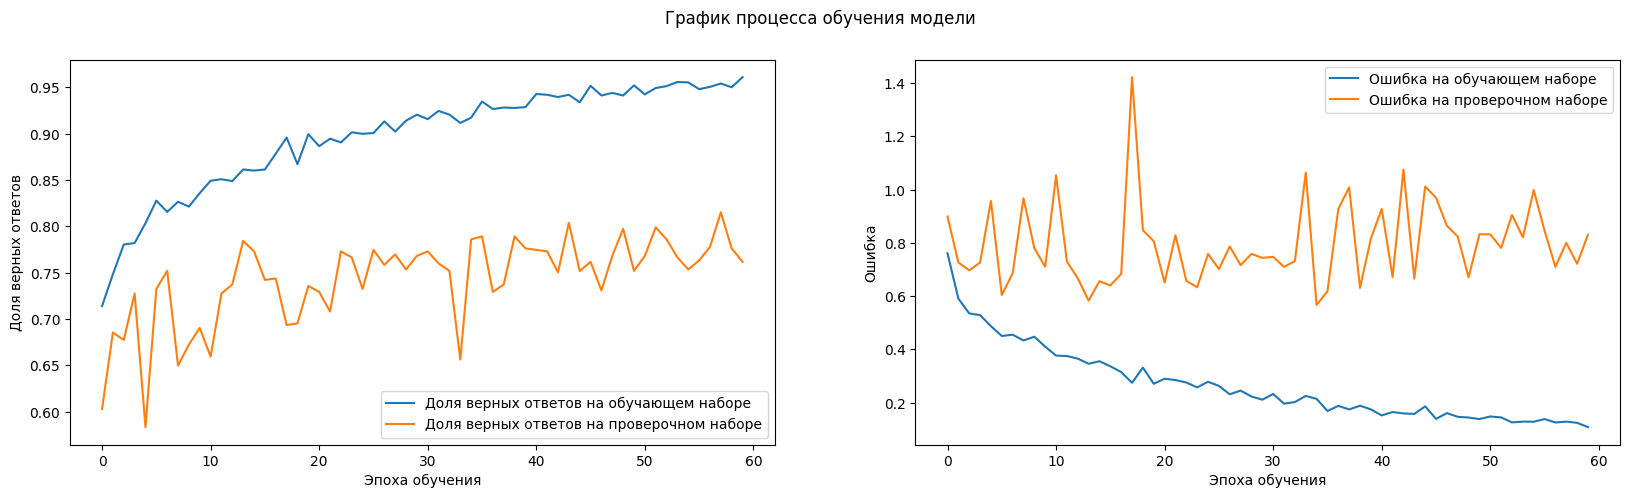

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 442ms/step


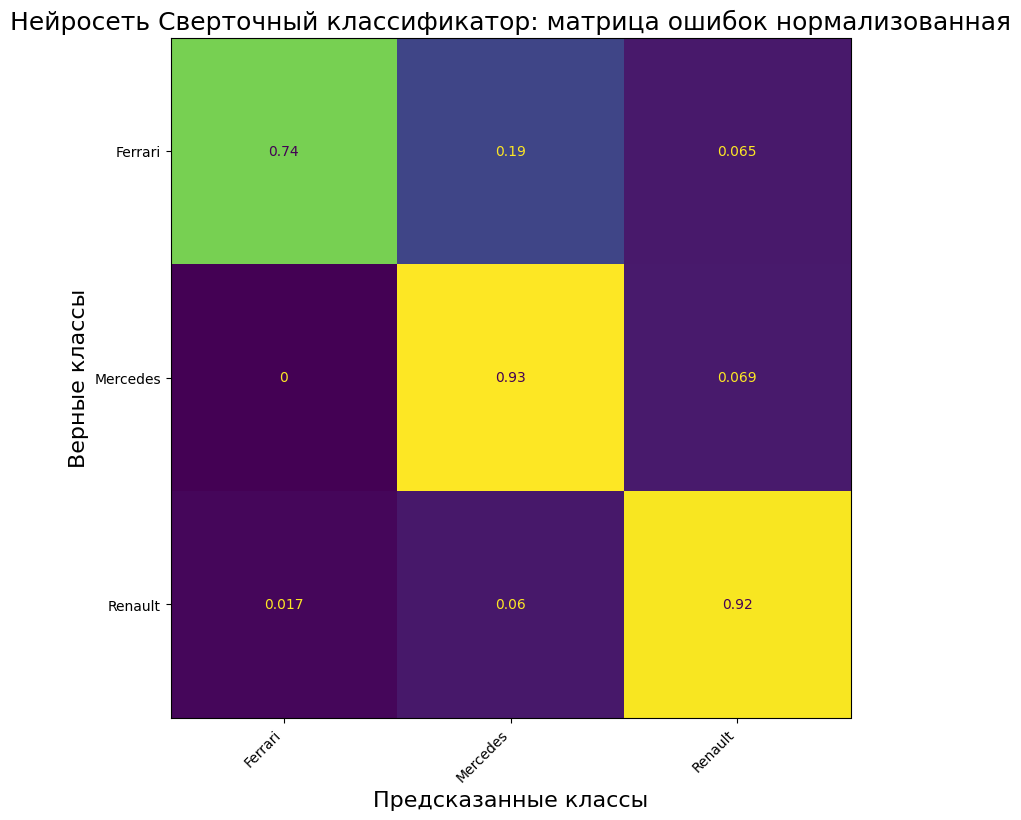

----------------------------------------------------------------------------------------------------
Нейросеть: Сверточный классификатор
Класс: Ferrari               74% сеть отнесла к классу Ferrari              - ВЕРНО :-)
Класс: Mercedes              93% сеть отнесла к классу Mercedes             - ВЕРНО :-)
Класс: Renault               92% сеть отнесла к классу Renault              - ВЕРНО :-)

Средняя точность распознавания:  87%


In [14]:
# Обучение модели и вывод оценки ее работы на тестовых данных
compile_train_eval_model(model,
                         train_generator,
                         validation_generator,
                         test_generator,
                         class_labels=CLASS_LIST,
                         title='Сверточный классификатор')

In [37]:
# использование готовой архитектуры
# Задание гиперпараметров

TRAIN_PATH          = '/content/cars'       # Папка для обучающего набора данных
TEST_PATH           = '/content/cars_test'  # Папка для тестового набора данных

TEST_SPLIT          = 0.1                   # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                   # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 224                   # Ширина изображения для нейросети
IMG_HEIGHT          = 224                    # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.7, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = True                  # Горизонтальное отражение разрешено

EPOCHS              = 15                    # Число эпох обучения
BATCH_SIZE          = 24                    # Размер батча для обучения модели
OPTIMIZER           = Adam(0.0001)          # Оптимизатор

In [38]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

try:
  os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
except:
  pass

train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса

    try:
      os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    except:
      pass

    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} машин, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса Ferrari: 794 машин, для теста выделено файлов: 79
Размер класса Mercedes: 847 машин, для теста выделено файлов: 84
Размер класса Renault: 860 машин, для теста выделено файлов: 86
Общий размер базы: 2501, выделено для обучения: 2252, для теста: 249


In [42]:
# Генераторы изображений

# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    #  rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                  #  rescale=1. / 255.
                )

In [43]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 1803 images belonging to 3 classes.
Found 449 images belonging to 3 classes.
Found 1175 images belonging to 3 classes.


In [19]:
# Функция компиляции и обучения модели нейронной сети
# По окончанию выводит графики обучения

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        # batch_size=batch_size,
                        validation_data=val_data)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода результатов оценки модели на заданных данных

def eval_model(model,
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                    # модель нейронной сети
                             train_data,               # обучающие данные
                             val_data,                 # проверочные данные
                             test_data,                # тестовые данные
                             class_labels=CLASS_LIST,  # список меток классов
                             title='',                 # название модели
                             optimizer=OPTIMIZER,      # оптимизатор
                             epochs=EPOCHS,            # количество эпох обучения
                             batch_size=BATCH_SIZE,    # размер батча
                             graph_size=(20, 5),       # размер полотна для графиков обучения
                             cm_size=(10, 10)          # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, test_data[0][0], test_data[0][1],
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

In [44]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax

# Задаем параметры входящей картинки
img_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
img_size  = (IMG_HEIGHT, IMG_WIDTH)
my_random = None
# Задаем имя модели
model_name = 'EfficientNetB0'
# Генерируем экземпляр модели EfficientNetB0
base_model = EfficientNetB0(include_top = False, weights = "imagenet", input_shape = img_shape, pooling = 'max')
# Создаем выходной слой
x = base_model.output
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(0.016), activity_regularizer = regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006), activation = 'relu')(x)
x = Dropout(rate = .45, seed = my_random)(x)
#Создаем выходной полносвязный слой и присоединяем его к предыдущим слоям (количество нейронов совпадает с количеством классов
output = Dense(CLASS_COUNT, activation = 'softmax')(x)
# Собираем модель вместе
model = Model(inputs = base_model.input, outputs = output)
model.compile(optimizer=Adamax(.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Вывод сводки
#model.summary()

Epoch 1/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.5333 - loss: 19.3661 - val_accuracy: 0.4410 - val_loss: 12.4473
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 37s 488ms/step - accuracy: 0.3498 - loss: 6.8885 - val_accuracy: 0.3742 - val_loss: 7.1945
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 37s 489ms/step - accuracy: 0.3365 - loss: 6.3508 - val_accuracy: 0.3675 - val_loss: 6.0236
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 37s 492ms/step - accuracy: 0.3581 - loss: 5.8143 - val_accuracy: 0.3408 - val_loss: 5.5079
Epoch 5/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 37s 488ms/step - accuracy: 0.3246 - loss: 5.3577 - val_accuracy: 0.3385 - val_loss: 5.2078
Epoch 6/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 37s 489ms/step - accuracy: 0.3322 - loss: 4.9752 - val_accuracy: 0.3474 - val_loss: 4.6964
Epoch 7/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 37s 489ms/step - accuracy: 0.3586 - loss: 4.5890 - val_accuracy: 0.3474 - val_loss: 4.3692
Epoch 8/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 37s 490ms/step - accuracy: 0.3564 - loss: 4.2789 - val_accu

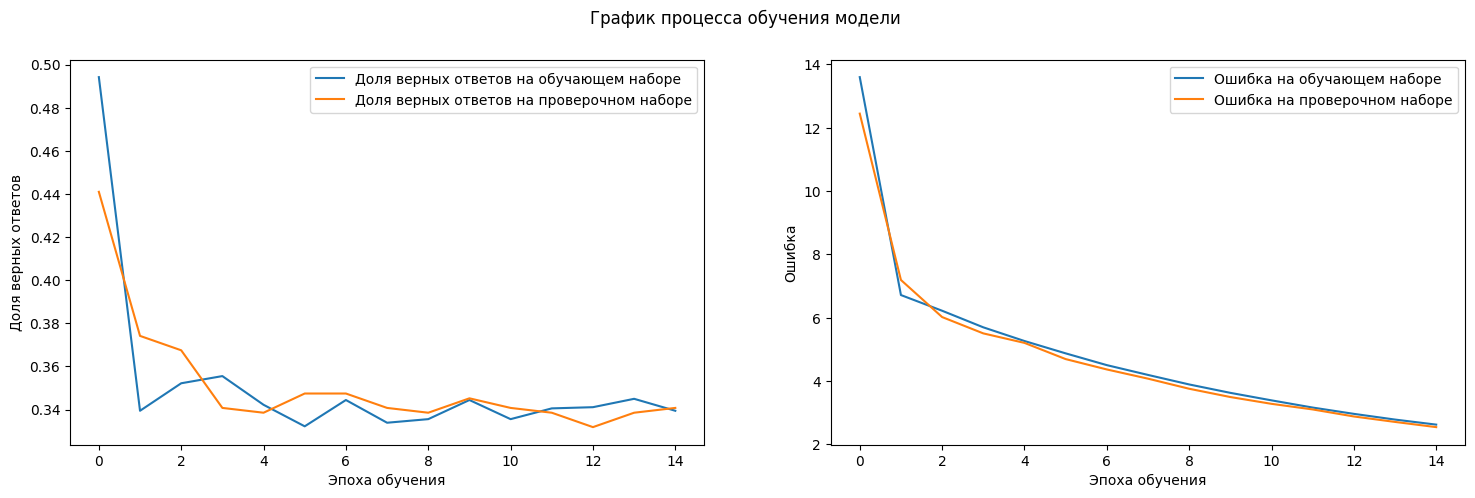

In [45]:
# Обучение модели с заданными параметрами
patience      = 1 # количество эпох, в течение которых необходимо отрегулировать lr, если отслеживаемое значение не улучшится
stop_patience = 6 # количество эпох ожидания перед остановкой обучения, если отслеживаемое значение не улучшится
threshold     = .9
factor        = .5
dwell         = True # если True и отслеживаемая метрика не улучшаются по сравнению с текущей эпохой, возвращают веса модели к весам предыдущей эпохи.
freeze        = False #
ask_epoch     = 10 # количество эпох, которые нужно выполнить, прежде чем спросить, хотите ли вы остановить обучение
batch_size = 20
# Размер пачки для валидации
test_batch_size = 50


history = model.fit (x = train_generator,  epochs = EPOCHS, validation_data = validation_generator, validation_steps = None,  shuffle = False,  initial_epoch = 0, verbose=1)


# Вывод графиков точности и ошибки
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
fig.suptitle('График процесса обучения модели')
ax1.plot(history.history['accuracy'],
            label='Доля верных ответов на обучающем наборе')
ax1.plot(history.history['val_accuracy'],
            label='Доля верных ответов на проверочном наборе')
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel('Эпоха обучения')
ax1.set_ylabel('Доля верных ответов')
ax1.legend()

ax2.plot(history.history['loss'],
            label='Ошибка на обучающем наборе')
ax2.plot(history.history['val_loss'],
            label='Ошибка на проверочном наборе')
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel('Эпоха обучения')
ax2.set_ylabel('Ошибка')
ax2.legend()
plt.show()
